<a href="https://colab.research.google.com/github/swimbeginner/TensorFlow2/blob/main/NeuralNet_12262020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Neural nets 
[from google crash course](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/intro_to_neural_nets.ipynb?utm_source=mlcc&utm_campaign=colab-external&utm_medium=referral&utm_content=intro_to_nn_tf2-colab&hl=en)

In [1]:
%tensorflow_version 2.x

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
#from tensorflow import feature_column
from tensorflow.keras import layers
from matplotlib import pyplot as plt

pd.options.display.max_rows=10
pd.options.display.float_format="{:.1f}".format

print("imported modeules")

imported modeules


In [4]:
train_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
train_df = train_df.reindex(np.random.permutation(train_df.index)) # shuffle the examples
test_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")

In [5]:
train_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
3227,-117.9,34.1,36.0,3097.0,667.0,1484.0,634.0,3.2,235300.0
2376,-117.5,34.3,35.0,1529.0,338.0,688.0,256.0,4.1,108000.0
13380,-121.9,36.6,34.0,2351.0,440.0,1063.0,428.0,3.7,278000.0
5991,-118.2,33.8,45.0,455.0,92.0,394.0,89.0,5.0,165700.0
5629,-118.2,34.0,44.0,1629.0,420.0,1893.0,387.0,2.3,137500.0


In [6]:
#@title Convert raw values to their Z-scores 

# Calculate the Z-scores of each column in the training set:
train_df_mean = train_df.mean()
train_df_std = train_df.std()
train_df_norm = (train_df - train_df_mean)/train_df_std

# Calculate the Z-scores of each column in the test set.
test_df_mean = test_df.mean()
test_df_std = test_df.std()
test_df_norm = (test_df - test_df_mean)/test_df_std

print("Normalized the values.")

Normalized the values.


## Represent data

The following code cell creates a feature layer containing three features:

* `latitude` X `longitude` (a feature cross)
* `median_income`
* `population`

This code cell specifies the features that you'll ultimately train the model on and how each of those features will be represented. The transformations (collected in `my_feature_layer`) don't actually get applied until you pass a DataFrame to it, which will happen when we train the model. 

In [25]:
# Create an empty list that will eventually hold all created feature columns.
feature_columns = []

# We scaled all the columns, including latitude and longitude, into their
# Z scores. So, instead of picking a resolution in degrees, we're going
# to use resolution_in_Zs.  A resolution_in_Zs of 1 corresponds to 
# a full standard deviation. 
resolution_in_Zs = 0.3  # 3/10 of a standard deviation.

# Create a bucket feature column for latitude.
latitude_as_a_numeric_column = tf.feature_column.numeric_column("latitude")
latitude_boundaries = list(np.arange(int(min(train_df_norm['latitude'])), 
                                     int(max(train_df_norm['latitude'])), 
                                     resolution_in_Zs))
latitude = tf.feature_column.bucketized_column(latitude_as_a_numeric_column, latitude_boundaries)

longitude_as_a_numeric_column = tf.feature_column.numeric_column("longitude")
longitude_boundaries = list(np.arange(int(min(train_df_norm['longitude'])), 
                                      int(max(train_df_norm['longitude'])), 
                                      resolution_in_Zs))
longitude = tf.feature_column.bucketized_column(longitude_as_a_numeric_column, 
                                                longitude_boundaries)
# Create a feature cross of latitude and longitude.
latitude_x_longitude = tf.feature_column.crossed_column([latitude, longitude], hash_bucket_size=100)
crossed_feature = tf.feature_column.indicator_column(latitude_x_longitude)
feature_columns.append(crossed_feature)  

# Represent median_income as a floating-point value.
median_income = tf.feature_column.numeric_column("median_income")
feature_columns.append(median_income)

# Represent population as a floating-point value.
population = tf.feature_column.numeric_column("population")
feature_columns.append(population)

# Convert the list of feature columns into a layer that will later be fed into
# the model. 
my_feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [26]:
#@title Define the plotting function.

def plot_the_loss_curve(epochs, mse):
  """Plot a curve of loss vs. epoch."""

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Mean Squared Error")

  plt.plot(epochs, mse, label="Loss")
  plt.legend()
  plt.ylim([mse.min()*0.95, mse.max() * 1.03])
  plt.show()  

print("Defined the plot_the_loss_curve function.")

Defined the plot_the_loss_curve function.


In [27]:
#title Define functions to create and train a linear regression model
def create_model(my_learning_rate, feature_layer):
  """Create and compile a simple linear regression model."""
  # Most simple tf.keras models are sequential.
  model = tf.keras.models.Sequential()

  # Add the layer containing the feature columns to the model.
  model.add(feature_layer)

  # Add one linear layer to the model to yield a simple linear regressor.
  model.add(tf.keras.layers.Dense(units=1, input_shape=(1,)))

  # Construct the layers into a model that TensorFlow can execute.
  model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.MeanSquaredError()])

  return model           


def train_model(model, dataset, epochs, batch_size, label_name):
  """Feed a dataset into the model in order to train it."""

  # Split the dataset into features and label.
  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array(features.pop(label_name))
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=True)

  # Get details that will be useful for plotting the loss curve.
  epochs = history.epoch
  hist = pd.DataFrame(history.history)
  rmse = hist["mean_squared_error"]

  return epochs, rmse   

print("Defined the create_model and train_model functions.")

Defined the create_model and train_model functions.


In [29]:
tf.keras.layers.Dense?

Epoch 1/15
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
17/17 [==============================] - 1s 2ms/step - loss: 0.7252 - mean_squared_error: 0.7252
Epoch 2/15
17/17 [==============================] - 0s 2ms/step - loss: 0.4810 - mean_squared_error: 0.4810
Epoch 3/15
17/17 [==============================] - 0s 2ms/step - loss: 0.4143 - mean_squared_error: 0.4143
Epoch 4/15
17/17 [==============================] - 0s 2ms/step - loss: 0.3946 - mean_squared_error: 0.3946
Epoch 5/15
17/17 [==============================] - 0s 2ms/step - loss: 0.3754 - mean_squared_error: 0.3754
Epoch 6/15
17/17 [==============================] - 0s 2ms/step - loss: 0.3591 - mean_squared_error: 0.3591
Epoch 7/15
17/17 [==============================] - 0s 2ms/step - loss: 0.3568 - mean_squared_error: 0.3568
Epoch 8/15
17/17 [==============================] - 0s 2ms/step - loss: 0.3731 - mean_squared_error: 0.3731
Epoch 9/15
17/17 [========

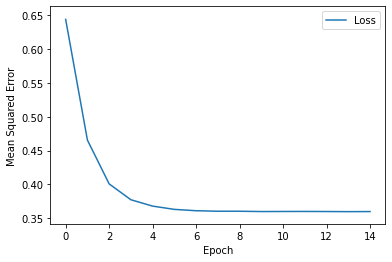


 Evaluate the linear regression model against the test set:
Consider rewriting this model with the Functional API.
3/3 [==============================] - 0s 4ms/step - loss: 0.3953 - mean_squared_error: 0.3953


[0.39529672265052795, 0.39529672265052795]

In [28]:
# The following variables are the hyperparameters.
learning_rate = 0.01
epochs = 15
batch_size = 1000
label_name = "median_house_value"

# Establish the model's topography.
my_model = create_model(learning_rate, my_feature_layer)

# Train the model on the normalized training set.
epochs, mse = train_model(my_model, train_df_norm, epochs, batch_size, label_name)
plot_the_loss_curve(epochs, mse)

test_features = {name:np.array(value) for name, value in test_df_norm.items()}
test_label = np.array(test_features.pop(label_name)) # isolate the label
print("\n Evaluate the linear regression model against the test set:")
my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size)

## Define a deep neural net model

The `create_model` function defines the topography of the deep neural net, specifying the following:

* The number of [layers](https://developers.google.com/machine-learning/glossary/#layer) in the deep neural net.
* The number of [nodes](https://developers.google.com/machine-learning/glossary/#node) in each layer.

The `create_model` function also defines the [activation function](https://developers.google.com/machine-learning/glossary/#activation_function) of each layer.

In [40]:
def create_model(my_learning_rate, my_feature_layer):
  """Create and compile a simple linear regression model."""
  # Most simple tf.keras models are sequential.
  model = tf.keras.models.Sequential()

  # Add the layer containing the feature columns to the model.
  model.add(my_feature_layer)

  # Describe the topography of the model by calling the tf.keras.layers.Dense
  # method once for each layer. We've specified the following arguments:
  #   * units specifies the number of nodes in this layer.
  #   * activation specifies the activation function (Rectified Linear Unit).
  #   * name is just a string that can be useful when debugging.

  # Define the first hidden layer with 20 nodes.   
  model.add(tf.keras.layers.Dense(units=12, 
                                  activation='relu', 
                                  name='Hidden1'))
  
  # Define the second hidden layer with 12 nodes. 
  model.add(tf.keras.layers.Dense(units=10, 
                                  activation='relu', 
                                  name='Hidden2'))
  
  # Define the output layer.
  model.add(tf.keras.layers.Dense(units=1,  
                                  name='Output'))                              
  
  model.compile(optimizer=tf.keras.optimizers.Adam(lr=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.MeanSquaredError()])

  return model

In [41]:
def train_model(model, dataset, epochs, label_name,
                batch_size):
  """Train the model by feeding it data."""

  # Split the dataset into features and label.
  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array(features.pop(label_name))
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=True) 

  # The list of epochs is stored separately from the rest of history.
  epochs = history.epoch
  
  # To track the progression of training, gather a snapshot
  # of the model's mean squared error at each epoch. 
  hist = pd.DataFrame(history.history)
  mse = hist["mean_squared_error"]

  return epochs, mse

Epoch 1/40
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
17/17 [==============================] - 1s 3ms/step - loss: 0.7116 - mean_squared_error: 0.7116
Epoch 2/40
17/17 [==============================] - 0s 3ms/step - loss: 0.3881 - mean_squared_error: 0.3881
Epoch 3/40
17/17 [==============================] - 0s 3ms/step - loss: 0.3422 - mean_squared_error: 0.3422
Epoch 4/40
17/17 [==============================] - 0s 3ms/step - loss: 0.3383 - mean_squared_error: 0.3383
Epoch 5/40
17/17 [==============================] - 0s 3ms/step - loss: 0.3443 - mean_squared_error: 0.3443
Epoch 6/40
17/17 [==============================] - 0s 3ms/step - loss: 0.3309 - mean_squared_error: 0.3309
Epoch 7/40
17/17 [==============================] - 0s 3ms/step - loss: 0.3338 - mean_squared_error: 0.3338
Epoch 8/40
17/17 [==============================] - 0s 3ms/step - loss: 0.3382 - mean_squared_error: 0.3382
Epoch 9/40
17/17 [========

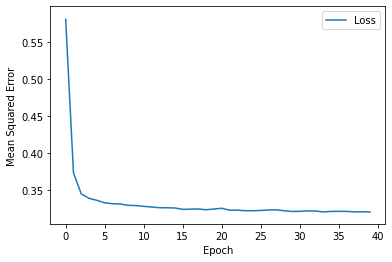


 Evaluate the new model against the test set:
Consider rewriting this model with the Functional API.
3/3 [==============================] - 0s 5ms/step - loss: 0.3619 - mean_squared_error: 0.3619


[0.36186519265174866, 0.36186519265174866]

In [43]:
# The following variables are the hyperparameters.
learning_rate = 0.01
epochs = 40
batch_size = 1000

# Specify the label
label_name = "median_house_value"

# Establish the model's topography.
my_model = create_model(learning_rate, my_feature_layer)

# Train the model on the normalized training set. We're passing the entire
# normalized training set, but the model will only use the features
# defined by the feature_layer.
epochs, mse = train_model(my_model, train_df_norm, epochs, 
                          label_name, batch_size)
plot_the_loss_curve(epochs, mse)

# After building a model against the training set, test that model
# against the test set.
test_features = {name:np.array(value) for name, value in test_df_norm.items()}
test_label = np.array(test_features.pop(label_name)) # isolate the label
print("\n Evaluate the new model against the test set:")
my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size)

#DNN will make better predictions than the linear regression model.

##Regularization

In [85]:
def create_model(my_learning_rate, my_feature_layer):
  """Create and compile a simple linear regression model."""
  # Most simple tf.keras models are sequential.
  model = tf.keras.models.Sequential()

  # Add the layer containing the feature columns to the model.
  model.add(my_feature_layer)

  # Describe the topography of the model by calling the tf.keras.layers.Dense
  # method once for each layer. We've specified the following arguments:
  #   * units specifies the number of nodes in this layer.
  #   * activation specifies the activation function (Rectified Linear Unit).
  #   * name is just a string that can be useful when debugging.

  # Define the first hidden layer with 20 nodes.   
  model.add(tf.keras.layers.Dense(units=10, 
                                  activation='relu', 
                           #       kernel_regularizer=tf.keras.regularizers.l2(0.02),
                                  name='Hidden1'))
  
  #model.add(tf.keras.layers.Dropout(rate=0.05))
  # Define the second hidden layer with 12 nodes. 
  model.add(tf.keras.layers.Dense(units=5, 
                                  activation='relu', 
                          #      kernel_regularizer=tf.keras.regularizers.l2(0.02),
                                  name='Hidden2'))
  
  # Define the output layer.
  model.add(tf.keras.layers.Dense(units=1, 
                                   
                                  name='Output'))                              
  
  model.compile(optimizer=tf.keras.optimizers.Adam(lr=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.MeanSquaredError()])

  return model

Epoch 1/140
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
17/17 [==============================] - 1s 4ms/step - loss: 0.9342 - mean_squared_error: 0.9342
Epoch 2/140
17/17 [==============================] - 0s 4ms/step - loss: 0.5995 - mean_squared_error: 0.5995
Epoch 3/140
17/17 [==============================] - 0s 4ms/step - loss: 0.4345 - mean_squared_error: 0.4345
Epoch 4/140
17/17 [==============================] - 0s 4ms/step - loss: 0.3770 - mean_squared_error: 0.3770
Epoch 5/140
17/17 [==============================] - 0s 3ms/step - loss: 0.3453 - mean_squared_error: 0.3453
Epoch 6/140
17/17 [==============================] - 0s 3ms/step - loss: 0.3457 - mean_squared_error: 0.3457
Epoch 7/140
17/17 [==============================] - 0s 3ms/step - loss: 0.3334 - mean_squared_error: 0.3334
Epoch 8/140
17/17 [==============================] - 0s 3ms/step - loss: 0.3354 - mean_squared_error: 0.3354
Epoch 9/140
17/17 

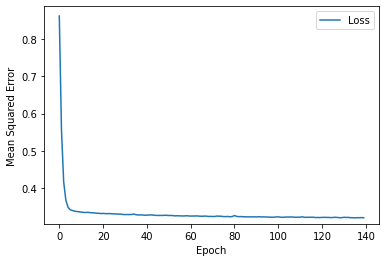


 Evaluate the new model against the test set:
Consider rewriting this model with the Functional API.
3/3 [==============================] - 0s 4ms/step - loss: 0.3617 - mean_squared_error: 0.3617


[0.3616933524608612, 0.3616933524608612]

In [86]:
# The following variables are the hyperparameters.
learning_rate = 0.005
epochs = 140
batch_size = 1000

label_name = "median_house_value"

# Establish the model's topography.
my_model = create_model(learning_rate, my_feature_layer)

# Train the model on the normalized training set.
epochs, mse = train_model(my_model, train_df_norm, epochs, 
                          label_name, batch_size)
plot_the_loss_curve(epochs, mse)

test_features = {name:np.array(value) for name, value in test_df_norm.items()}
test_label = np.array(test_features.pop(label_name)) # isolate the label
print("\n Evaluate the new model against the test set:")
my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size)